## Testing hypothesis 3 in a Big Data context using PySpark
---

**_Hypothesis_**: Reviews with longer text have higher helpfulness ratings.

   - **Metric**: Correlation coefficient (e.g., Pearson's correlation) between review length and helpfulness ratings. Plot the correlation coefficient as a function of the review length.

- **Missing Values**:

  - `review/text`: set missing values as empty string
  - `review/helpfulness`: remove the entire sample

- **Data Transformation**:

  - `review/text`: Count the number of words in each review removing punctuation and stopwords
  - `review/helpfulness`: $helpfulness = \frac{x}{y} \sqrt(y)$


In [1]:
# Connect to MongoDB

import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_rating']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy_analyze import *

# Remove the samples which have no score or helpfulness data
pipeline_remove = {'$match':{
                        'review/text':{'$exists':True},
                        'N_helpful'	:{'$exists':True, '$ne':0},
                        'Tot_votes'	:{'$exists':True, '$ne':0}
                        }
                }

# Retain only the required fields
pipeline_project = {'$project':{
                            'review/text':1,
                            'review/helpfulness_rate':{'$multiply':[
                                                                {'$divide':['$N_helpful','$Tot_votes']},
                                                                {'$sqrt':'$Tot_votes'}
                                                                ]
                                                       },
                            'N_helpful':1,
                            'Tot_votes':1,
                            '_id':0,
                                }
                }

books_rating = books.aggregate([pipeline_remove,pipeline_project])

# Convert the cursor to a dataframe
books_rating = pd.DataFrame(list(books_rating))

books_rating.head()

,review/text,N_helpful,Tot_votes,review/helpfulness_rate
0,"This is a self-published book, and if you want...",1,2,0.707107
1,I read the review directly under mine and I ha...,5,9,1.666667
2,Normally I'm not much into romance stories but...,8,8,2.828427
3,I feel I have to write to keep others from was...,4,4,2.000000
4,Everett Ferguson approaches the subject of ear...,2,3,1.154701


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from nltk.tokenize import word_tokenize
import string
    
def get_tokenize_length(text):
    '''This function takes a string and returns the length of a list of tokens after removing stopwords and punctuations
    
    # Parameters
    Input: String
    Output: List of tokens
    
    '''
        
    words = word_tokenize(text)
    words = [word.lower() for word in words if word not in stopwords and word not in string.punctuation]
    
    return len(words)

# Tokenize the reviews
books_rating['review_length'] = books_rating['review/text'].apply(get_tokenize_length)

# Store in MongoDB
#books_1 = database['books_hypothesis_1']
#books_1.insert_many(books_rating.to_dict('records'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreaalberti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreaalberti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The p-value for normality test of review/length is 0.0. The data is not normally distributed.
The p-value for normality test of review/helpfulness_rate is 0.0. The data is not normally distributed.
Since at least one of the variables is not normally distributed, we will use Spearman's correlation.
The p-value for correlation value: 0.271311678663446 between review/length and review/helpfulness_rate is 0.0. The correlation is significant.
The p-value for Kolmogorov-Smirnov test between review/length and review/helpfulness_rate is 0.0. The two variables do not follow the same distribution.
The p-value for Chi-Square test between review/length and review/helpfulness_rate is 0.0. The two variables are not independent.


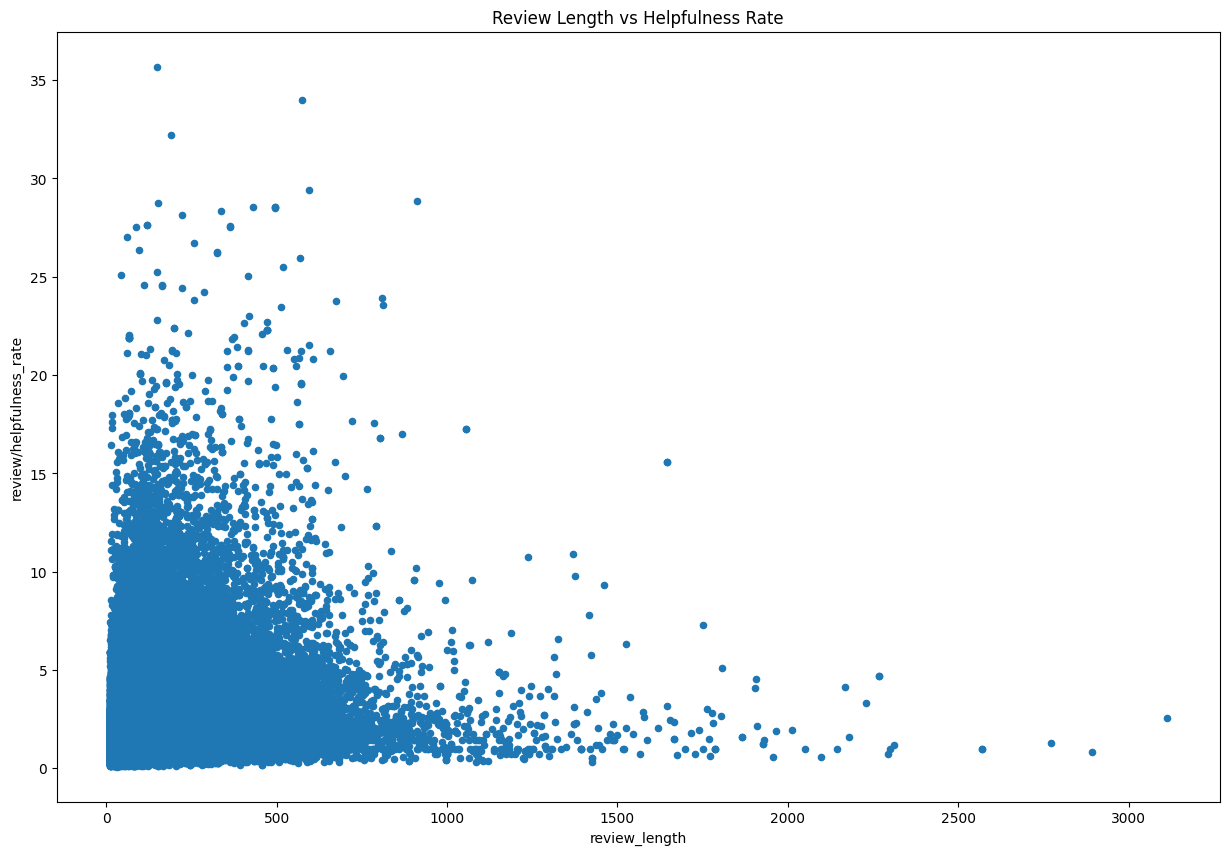

In [4]:
# Load the correct collection
books_1 = database['books_hypothesis_1']
books_rating = pd.DataFrame(books_1.find())
del books_rating['_id']
del books_rating['review/text']

# Filter out reviews with length less than 10
books_rating = books_rating[books_rating['review_length'] > 10]
books_rating = books_rating[books_rating['review/helpfulness_rate'] < 100]

# Plot the distribution of review length with respect to helpfulness rate
books_rating.plot(kind='scatter',x='review_length',y='review/helpfulness_rate',figsize=(15,10),title='Review Length vs Helpfulness Rate')

# Analyze
scipy_analize(books_rating['review_length'],'review/length', books_rating['review/helpfulness_rate'], 'review/helpfulness_rate', [1,2,3,4])

Group number: 250
Correlation Coefficient: 0.17664337179369882
P-value: 0.0

Group number: 500
Correlation Coefficient: 0.01621058840688147
P-value: 0.000727112969241666

Group number: 750
Correlation Coefficient: 0.00519994495537243
P-value: 0.6866960765072584

Group number: 3000
Correlation Coefficient: -0.10457094761317487
P-value: 7.791831986707664e-05



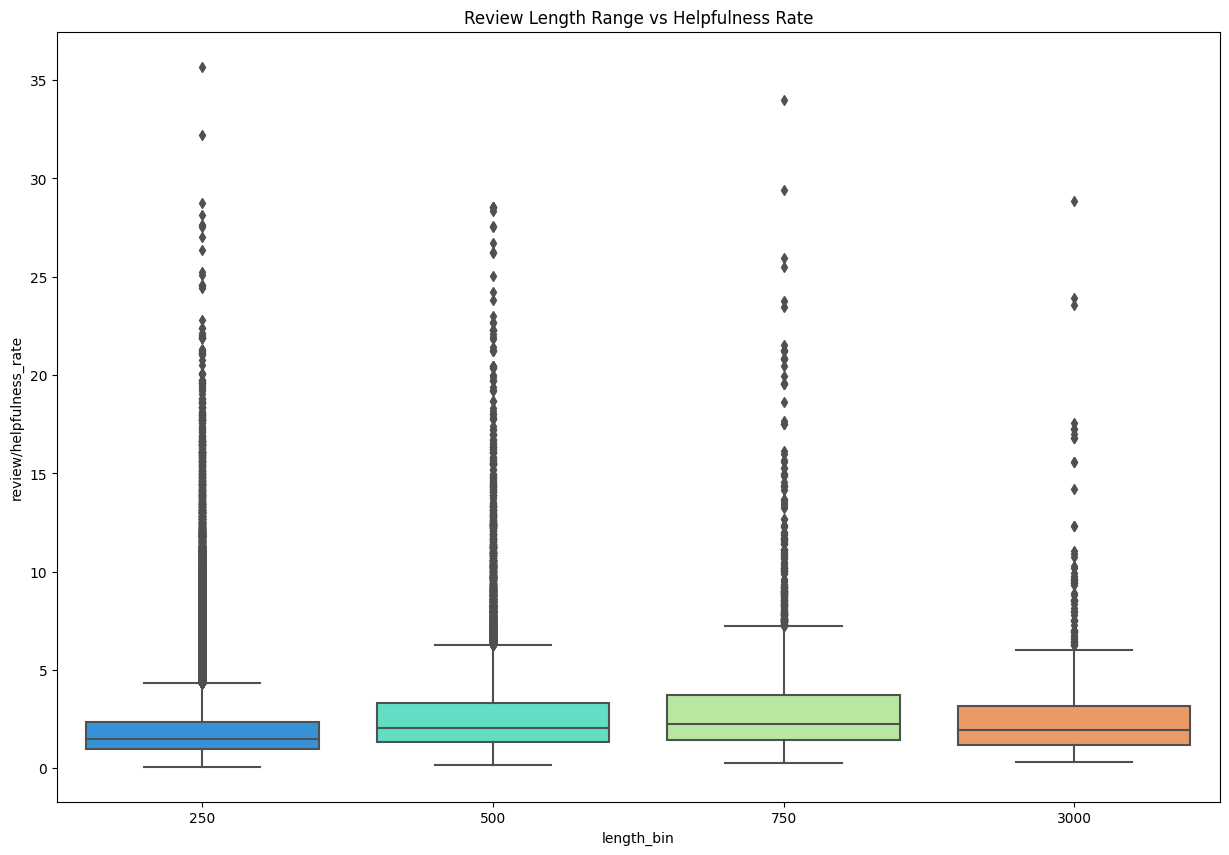

<Figure size 1500x1000 with 0 Axes>

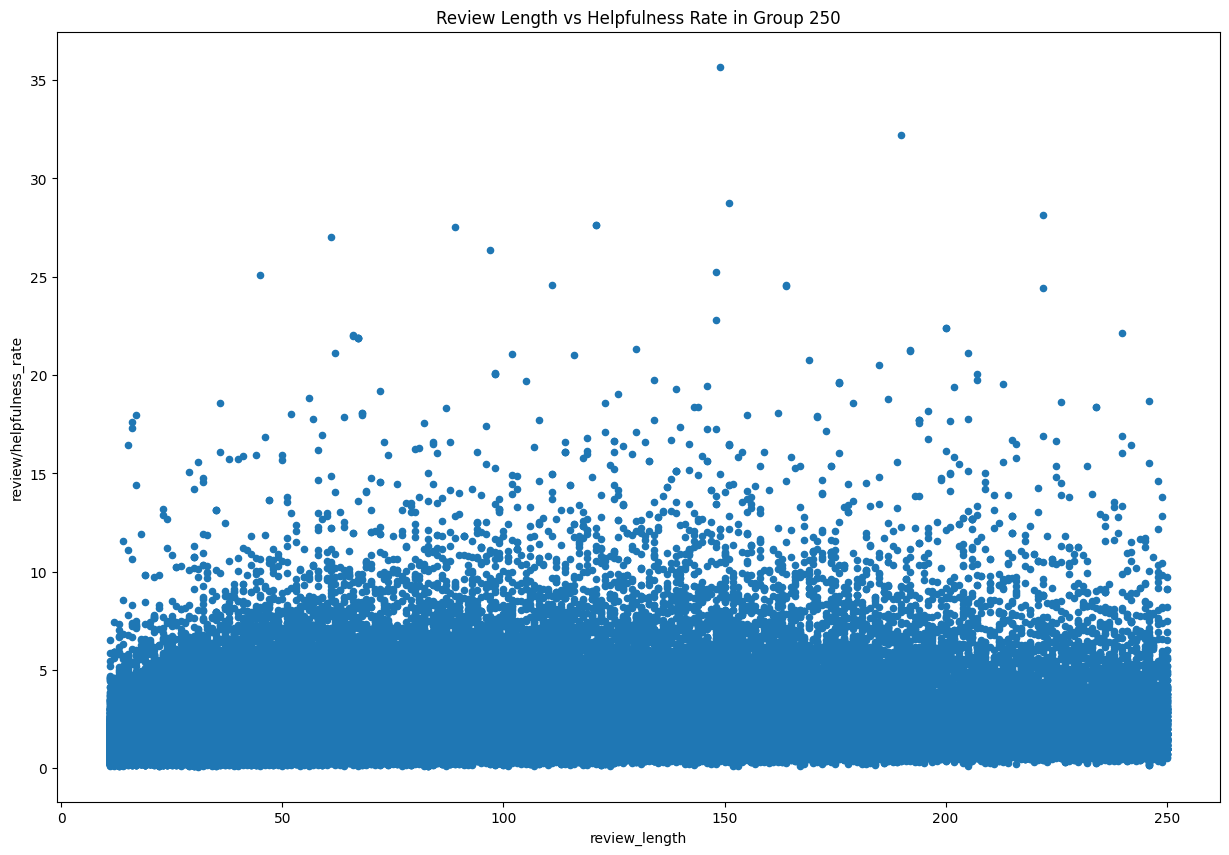

<Figure size 1500x1000 with 0 Axes>

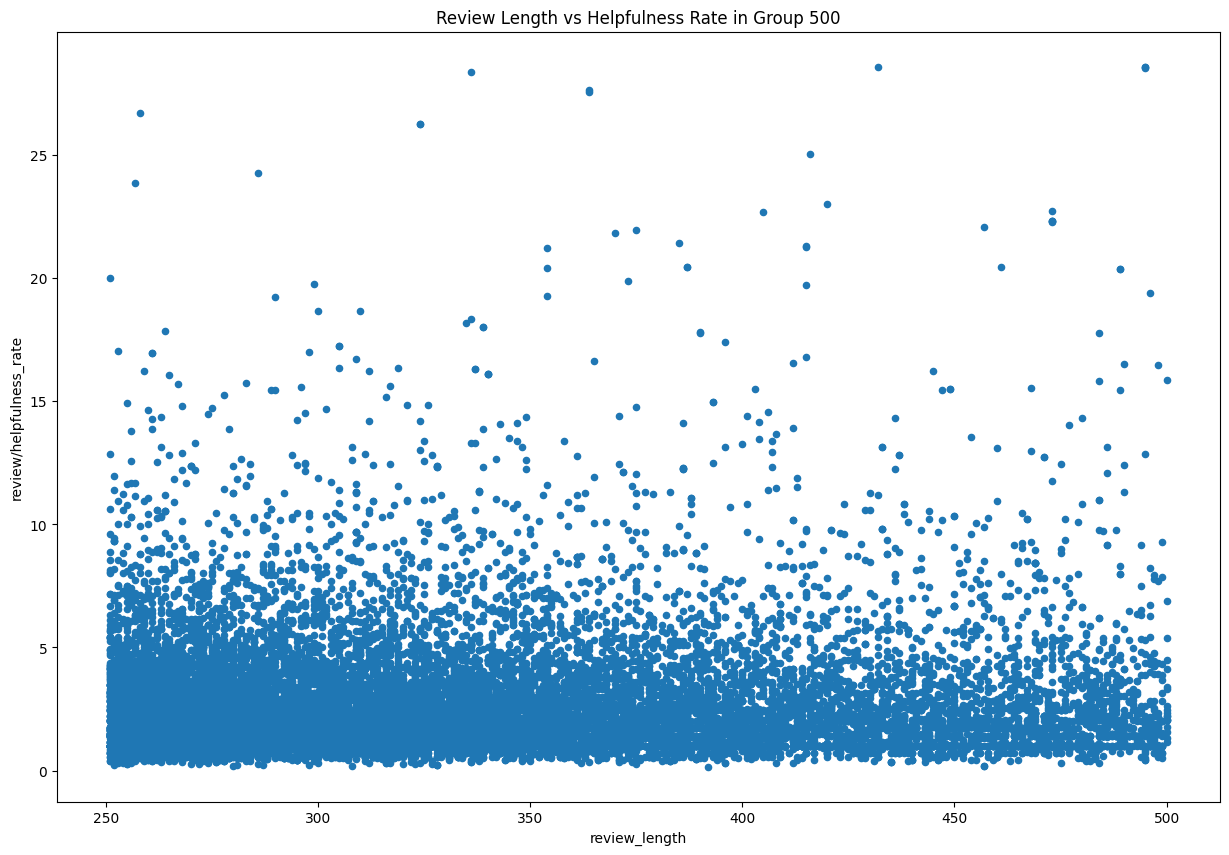

<Figure size 1500x1000 with 0 Axes>

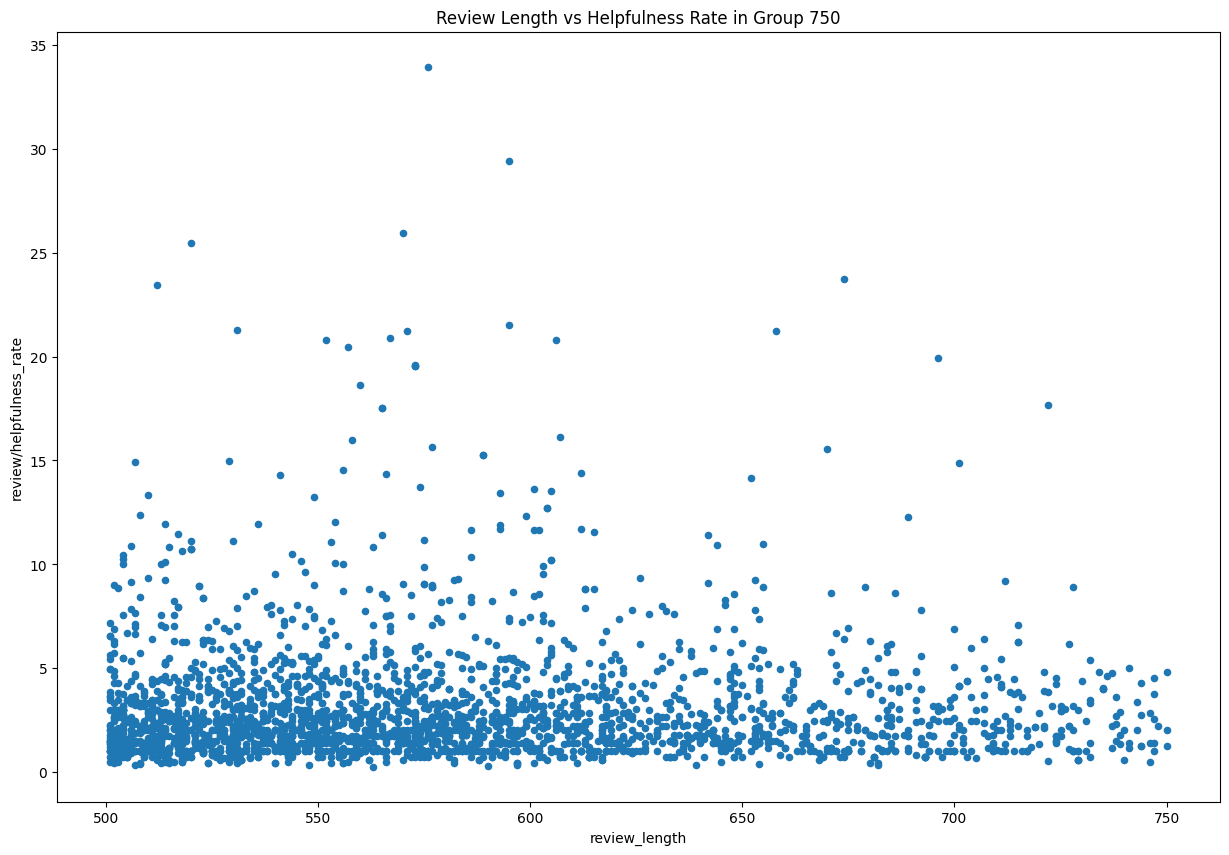

<Figure size 1500x1000 with 0 Axes>

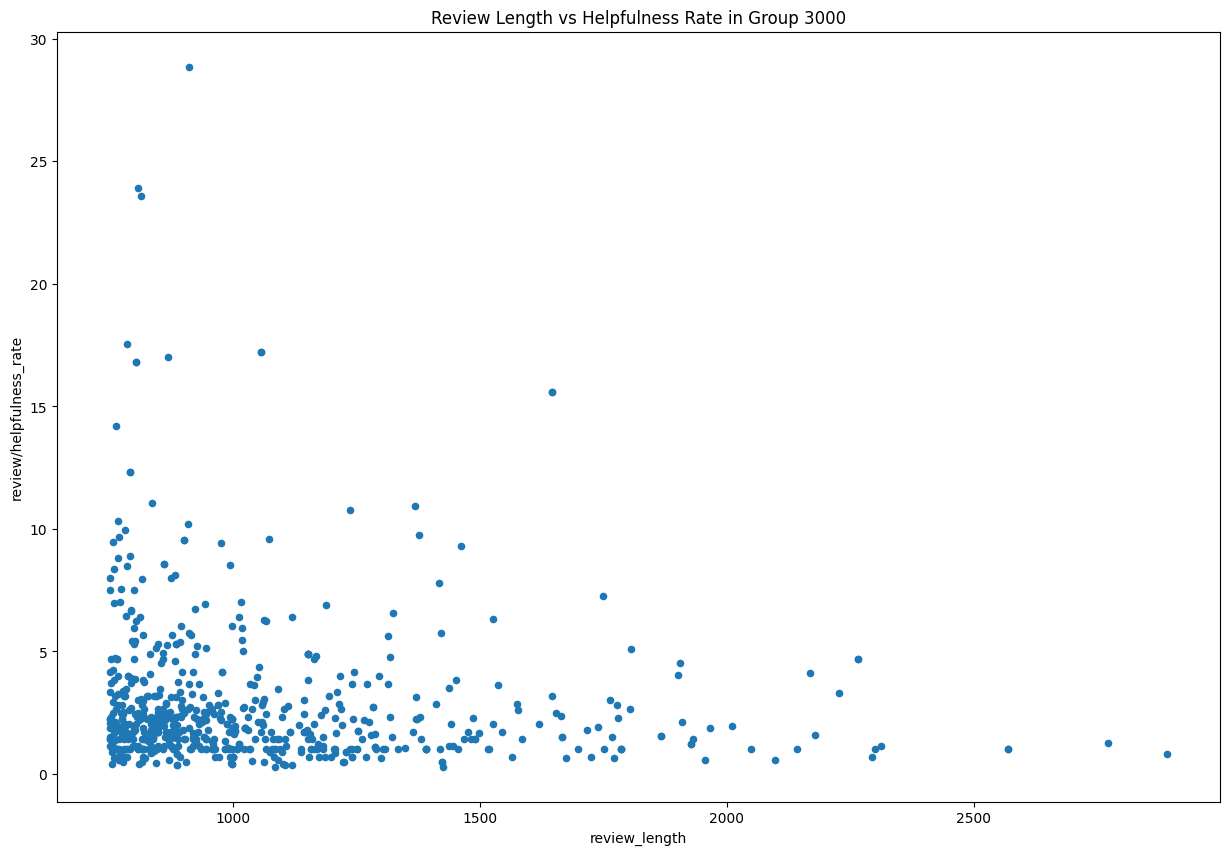

In [6]:
# Create 5 bins of review length
groups = [0, 250, 500, 750, 3000]
books_rating['length_bin'] = pd.cut(books_rating['review_length'], bins=groups, labels = [group for group in groups[1:]])
#books_rating.drop(books_rating.index[books_rating['length_bin'].isna().values], inplace=True)

import seaborn as sns

# Plot the distribution of review length with respect to helpfulness rate
plt.figure(figsize=(15,10))
sns.boxplot(x='length_bin', y='review/helpfulness_rate', data=books_rating, palette='rainbow')
plt.title('Review Length Range vs Helpfulness Rate')

import scipy

for el in groups[1:]:
    df = books_rating[books_rating['length_bin']==el]
    corr, pval = scipy.stats.kendalltau(df['review_length'], df['review/helpfulness_rate'])
    print(f'Group number: {el}\nCorrelation Coefficient: {corr}\nP-value: {pval}\n')
    plt.figure(figsize=(15,10))
    df.plot(kind='scatter',x='review_length',y='review/helpfulness_rate',figsize=(15,10),title=f'Review Length vs Helpfulness Rate in Group {el}')